In [1]:
instance = 1

In [2]:
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thl,r = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg}','r']) 
dx,dy,dthb,dthl,dr = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg}','\dot{r}']) 
ddx,ddy,ddthb,ddthl,ddr = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg}','\ddot{r}']) 

q = sym.Matrix([[x],[y],[thb],[thl],[r]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthl],[dr]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthl],[ddr]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
F,tau,GRFx,GRFy = sym.symbols(['F','\\tau','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x + 0.5*ll1*sym.sin(thl)],
                [y - 0.5*ll1*sym.cos(thl)],
                [thl]])

rl2 = sym.Matrix([[x + (0.5*ll1+r)*sym.sin(thl)],
                [y - (0.5*ll1+r)*sym.cos(thl)],
                [thl]])

pfoot = sym.Matrix([[x + (ll1+r)*sym.sin(thl)],
                [y - (ll1+r)*sym.cos(thl)]])

# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

vfoot = pfoot.jacobian(q)*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau]])
tau_l1 = sym.Matrix([[0],[0],[tau]])

F_l1 = sym.Matrix([[-F*sym.sin(thl)],[F*sym.cos(thl)],[0]])
F_l2 = sym.Matrix([[F*sym.sin(thl)],[-F*sym.cos(thl)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[0.5*ll2*GRFx*sym.cos(thl)+0.5*ll2*GRFy*sym.sin(thl)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1+F_l1).transpose()*Jl1[:,j]+(F_l2+GRF_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q


In [3]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thl,r,
            dx,dy,dthb,dthl,dr,
            ddx,ddy,ddthb,ddthl,ddr,
            F,tau,GRFx,GRFy]

lambEOM = {}

DOFs = ['x','y','thb','thl','r']

for dof_i, dof in enumerate(DOFs):
    lambEOM.update({dof: sym.lambdify(sym_list,EOM[dof_i],modules = [func_map])})
    
lamb_footy = sym.lambdify(sym_list,pfoot[1],modules = [func_map])
lamb_dxfoot = sym.lambdify(sym_list,vfoot[0],modules = [func_map])

In [4]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 150
m.N = RangeSet(N) 

P = 3
m.P = RangeSet(P)

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

joints = ['hip','knee']
m.J = Set(initialize = joints)

DOFs = ['x','y','thb','thl','r'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

WDOFs = ['X','Y',"THETA"] # absolute coordinates 
m.WDOF = Set(initialize = WDOFs) 

signs = ['ps','ng'] # sign set for positive and negative components
m.sgn = Set(initialize = signs)

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 0.9
    else: return 0.05
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 0.6
    else: return 0.3
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.P, m.DOF) # position
m.dq = Var(m.N, m.P, m.DOF) # velocity
m.ddq = Var(m.N, m.P, m.DOF) # acceleration

m.GRF = Var(m.N, m.P, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

m.force_a = Var(m.N, m.J) # actuator 
m.force_r = Var(m.N, m.P, m.J, m.sgn, bounds = (0,1)) # rebound 

# bound variables
for n in range(1,N+1):
    for p in range(1,P+1):
        m.q[n,p,'y'].setlb(0.0)
        m.q[n,p,'thb'].setlb(-np.pi/2)
        m.q[n,p,'thb'].setub(np.pi/2)
        m.GRF[n,p,'Y','ps'].setub(3.0)
            
# TIME AND INTEGRATION ---------------------------------------------------------------------------------------------------

# variable timestep
m.hm = Param(initialize = 0.02, mutable = True) # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
radau_mat = [[0.19681547722366, -0.06553542585020, 0.02377097434822],
 [0.39442431473909, 0.29207341166523, -0.04154875212600],
 [0.37640306270047, 0.51248582618842, 0.11111111111111]]

# aux variable to assist with scaling
m.acc = Var(m.N, m.P, m.DOF)
m.vel = Var(m.N, m.P, m.DOF)

# RADAU
def get_acc(m,n,p,dof):
    if n == 1:
        return Constraint.Skip
    if n > 1:
        return m.acc[n,p,dof] == m.hm*m.h[n]*sum([radau_mat[p-1][pp-1]*m.ddq[n,pp,dof] for pp in range(1,P+1)])
m.get_acc = Constraint(m.N, m.P, m.DOF, rule = get_acc)

def get_vel(m,n,p,dof):
    if n == 1:
        return Constraint.Skip
    if n > 1:
        return m.vel[n,p,dof] == m.hm*m.h[n]*sum([radau_mat[p-1][pp-1]*m.dq[n,pp,dof] for pp in range(1,P+1)])
m.get_vel = Constraint(m.N, m.P, m.DOF, rule = get_vel)

def Radau_p(m,n,p,dof):
    if n == 1:
        return Constraint.Skip
    if n > 1:
        return m.q[n,p,dof] == m.q[n-1,P,dof] + m.vel[n,p,dof]
m.integrate_p3 = Constraint(m.N, m.P, m.DOF, rule = Radau_p)

def Radau_v(m,n,p,dof):
    if n == 1:
        return Constraint.Skip
    if n > 1:
        return m.dq[n,p,dof] == m.dq[n-1,P,dof] + m.acc[n,p,dof]
m.integrate_v3 = Constraint(m.N, m.P, m.DOF, rule = Radau_v)

# BACKWARD EULER
# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,P,dof] == m.q[n-1,P,dof] + m.hm*m.h[n]*m.dq[n,P,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p1 = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,P,dof] == m.dq[n-1,P,dof] + m.hm*m.h[n]*m.ddq[n,P,dof]
    else:
        return Constraint.Skip 
m.integrate_v1 = Constraint(m.N, m.DOF, rule = BwEuler_v)

# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties

# variables
m.footy = Var(m.N, m.P, bounds = (0.0,None)) # foot position
m.footdx = Var(m.N, m.P, m.sgn, bounds = (0.0,None)) # foot velocity
m.friction_cone = Var(m.N, m.P, m.sgn, bounds = (0.0,None))
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

m.mu_k = Param(initialize = 1.2, mutable = True)
m.mu_s = Param(initialize = 2.4, mutable = True)
m.a_k = Var(m.N, m.P, bounds = (0.0, m.mu_s.value))

# constraints: aux variables
def def_footy(m,n,p):
    if n == 1 and p < P:
        return Constraint.Skip
    else:
        F_in = 0
        tau_in = 0
        Gx_in = 0
        Gy_in = 0
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
        m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
        m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
        m.q[n,p,'x'],m.q[n,p,'y'],m.q[n,p,'thb'],m.q[n,p,'thl'],m.q[n,p,'r'],
        m.dq[n,p,'x'],m.dq[n,p,'y'],m.dq[n,p,'thb'],m.dq[n,p,'thl'],m.dq[n,p,'r'],
        m.ddq[n,p,'x'],m.ddq[n,p,'y'],m.ddq[n,p,'thb'],m.ddq[n,p,'thl'],m.ddq[n,p,'r'],
        F_in,tau_in,Gx_in,Gy_in]
        
        return m.footy[n,p] == lamb_footy(*var_list)
m.def_footy = Constraint(m.N, m.P, rule = def_footy)

def def_friction_cone(m,n,p):
    if n == 1:
        return Constraint.Skip
    return m.friction_cone[n,p,'ps'] - m.friction_cone[n,p,'ng'] == m.a_k[n,p] - m.mu_k
m.def_friction_cone = Constraint(m.N, m.P, rule = def_friction_cone)

def def_footdx(m,n,p):
    if n == 1 and p < P:
        return Constraint.Skip
    else:
        F_in = 0
        tau_in = 0
        Gx_in = 0
        Gy_in = 0
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
        m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
        m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
        m.q[n,p,'x'],m.q[n,p,'y'],m.q[n,p,'thb'],m.q[n,p,'thl'],m.q[n,p,'r'],
        m.dq[n,p,'x'],m.dq[n,p,'y'],m.dq[n,p,'thb'],m.dq[n,p,'thl'],m.dq[n,p,'r'],
        m.ddq[n,p,'x'],m.ddq[n,p,'y'],m.ddq[n,p,'thb'],m.ddq[n,p,'thl'],m.ddq[n,p,'r'],
        F_in,tau_in,Gx_in,Gy_in]
        
        return m.footdx[n,p,'ps']-m.footdx[n,p,'ng'] == lamb_dxfoot(*var_list)
m.def_footdx = Constraint(m.N, m.P, rule = def_footdx)

def def_Gx(m,n,p):
    if n == 1:
        return Constraint.Skip
    return m.GRF[n,p,'X','ps'] + m.GRF[n,p,'X','ng'] == m.a_k[n,p]*m.GRF[n,p,'Y','ps']
m.def_Gx = Constraint(m.N, m.P, rule = def_Gx)

# constraints: complementarity
m.ground_varA = Var(m.N, m.ground_constraints)
m.ground_varB = Var(m.N, m.ground_constraints)

def def_ground_varA(m,n,gc):
    if n == 1:
        return Constraint.Skip
    if gc == 'contact':
        if n < N:
            return m.ground_varA[n,gc] == sum(m.footy[n+1,p] for p in range(1,P+1))
        else: 
            return m.ground_varA[n,gc] == sum(m.footy[n,p] for p in range(1,P+1))
    if gc == 'friction':
        return m.ground_varA[n,gc] == sum(m.footdx[n,p,'ps']+m.footdx[n,p,'ng'] for p in range(1,P+1))
    if gc == 'slip_ps':
        return m.ground_varA[n,gc] == sum(m.footdx[n,p,'ps'] for p in range(1,P+1))
    if gc == 'slip_ng':
        return m.ground_varA[n,gc] == sum(m.footdx[n,p,'ng'] for p in range(1,P+1))
m.def_ground_varA = Constraint(m.N, m.ground_constraints, rule = def_ground_varA)

def def_ground_varB(m,n,gc):
    if n == 1:
        return Constraint.Skip
    if gc == 'contact':
        return m.ground_varB[n,gc] == sum(BW*m.GRF[n,p,'Y','ps'] for p in range(1,P+1))
    if gc == 'friction':
        return m.ground_varB[n,gc] == sum(BW*m.friction_cone[n,p,'ps']+BW*m.friction_cone[n,p,'ng'] for p in range(1,P+1))
    if gc == 'slip_ps':
        return m.ground_varB[n,gc] == sum(BW*m.GRF[n,p,'X','ps'] for p in range(1,P+1))
    if gc == 'slip_ng':
        return m.ground_varB[n,gc] == sum(BW*m.GRF[n,p,'X','ng'] for p in range(1,P+1))
m.def_ground_varB = Constraint(m.N, m.ground_constraints, rule = def_ground_varB)

# complementarity
def ground_comp(m,n,gc):
    if n == 1:
        return Constraint.Skip
    return m.ground_penalty[n,gc] == m.ground_varA[n,gc]*m.ground_varB[n,gc]
m.ground_comp = Constraint(m.N, m.ground_constraints, rule = ground_comp)

# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# variables
m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))
m.joint_varA = Var(m.N, m.J, m.joint_constraints)
m.joint_varB = Var(m.N, m.J, m.joint_constraints)

m.jointp = Var(m.N, m.P, m.J)
m.jointv = Var(m.N, m.P, m.J)
m.power = Var(m.N, m.P, m.J)

for n in range(1,N+1):
    for p in range(1,P+1):
        m.jointp[n,p,'hip'].setlb(-np.pi/2)
        m.jointp[n,p,'hip'].setub(np.pi/2)
        m.jointp[n,p,'knee'].setlb(0)
        m.jointp[n,p,'knee'].setub(0.3)
        
def def_jointp(m,n,p,j):
    if n == 1 and p < P:
        return Constraint.Skip
    if j == 'hip':
        return m.jointp[n,p,j] == m.q[n,p,'thl'] - m.q[n,p,'thb']
    if j == 'knee':
        return m.jointp[n,p,j] == m.q[n,p,'r']
m.def_jointp = Constraint(m.N, m.P, m.J, rule = def_jointp)

def def_jointv(m,n,p,j):
    if n == 1 and p < P:
        return Constraint.Skip
    if j == 'hip':
        return m.jointv[n,p,j] == m.dq[n,p,'thl'] - m.dq[n,p,'thb']
    if j == 'knee':
        return m.jointv[n,p,j] == m.dq[n,p,'r']
m.def_jointv = Constraint(m.N, m.P, m.J, rule = def_jointv)

def def_power(m,n,p,j):
    if n == 1:
        return Constraint.Skip
    else:
        return m.power[n,p,j] == 9.81*m.force_a[n,j]*m.jointv[n,p,j]
m.def_power = Constraint(m.N, m.P, m.J, rule = def_power)

def def_joint_varA(m,n,j,jc):
    if n == 1:
        return Constraint.Skip
    if jc == 'up':
        if n < N:
            return m.joint_varA[n,j,jc] == sum(m.jointp[3,P,j].ub - m.jointp[n+1,p,j] for p in range(1,P+1))
        else:
            return m.joint_varA[n,j,jc] == sum(m.jointp[3,P,j].ub - m.jointp[n,p,j] for p in range(1,P+1))
    if jc == 'lo':
        if n < N:
            return m.joint_varA[n,j,jc] == sum(m.jointp[n+1,p,j] - m.jointp[3,P,j].lb for p in range(1,P+1))
        else:
            return m.joint_varA[n,j,jc] == sum(m.jointp[n,p,j] - m.jointp[3,P,j].lb for p in range(1,P+1))
m.def_joint_varA = Constraint(m.N, m.J, m.joint_constraints, rule = def_joint_varA)

# define aux variables
def def_joint_varB(m,n,j,jc):
    if n == 1:
        return Constraint.Skip
    if jc == 'up':
        return m.joint_varB[n,j,jc] == sum(BW*m.force_r[n,p,j,'ng'] for p in range(1,P+1))
    if jc == 'lo':
        return m.joint_varB[n,j,jc] == sum(BW*m.force_r[n,p,j,'ps'] for p in range(1,P+1))
m.def_joint_varB = Constraint(m.N, m.J, m.joint_constraints, rule = def_joint_varB)

# complementarity
def joint_comp(m,n,j,jc):
    if n == 1:
        return Constraint.Skip
    return m.joint_penalty[n,j,jc] == m.joint_varA[n,j,jc]*m.joint_varB[n,j,jc]
m.joint_comp = Constraint(m.N, m.J, m.joint_constraints, rule = joint_comp)

# stop ends of links from going through the floor
m.jointy = Var(m.N, m.P, m.J, bounds = (0.0,None))

# DYNAMICS ----------------------------------------------------------------------------------------------------------------
S = BW

def dynamics(m,n,p,dof):
    if n == 1:
        return Constraint.Skip
    else:
        F_in = m.force_a[n,'knee'] + m.force_r[n,p,'knee','ps'] - m.force_r[n,p,'knee','ng']
        tau_in = m.force_a[n,'hip'] + m.force_r[n,p,'hip','ps'] - m.force_r[n,p,'hip','ng']
        Gx_in = m.GRF[n,p,'X','ps'] - m.GRF[n,p,'X','ng']
        Gy_in = m.GRF[n,p,'Y','ps']
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
        m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
        m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
        m.q[n,p,'x'],m.q[n,p,'y'],m.q[n,p,'thb'],m.q[n,p,'thl'],m.q[n,p,'r'],
        m.dq[n,p,'x'],m.dq[n,p,'y'],m.dq[n,p,'thb'],m.dq[n,p,'thl'],m.dq[n,p,'r'],
        m.ddq[n,p,'x'],m.ddq[n,p,'y'],m.ddq[n,p,'thb'],m.ddq[n,p,'thl'],m.ddq[n,p,'r'],
        S*F_in,S*tau_in,S*Gx_in,S*Gy_in]
    
    return lambEOM[dof](*var_list) == 0
m.dynamics = Constraint(m.N, m.P, m.DOF, rule = dynamics)

# OBJECTIVE --------------------------------------------------------------------------------------------------------------
def MinPenalty(m):
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,gc]
        for j in joints:
            for jc in joint_constraints:
                penalty_sum += m.joint_penalty[n,j,jc]
    return penalty_sum
m.MinPenalty = Objective(rule = MinPenalty)

In [5]:
def init_opt(): # initializes solver
    opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
    opt.options["linear_solver"] = 'ma97'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = 30000 # maximum number of iterations
    opt.options["max_cpu_time"] = 3600 # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt

In [6]:
def euler_mode(m):
    m.integrate_p1.activate()
    m.integrate_v1.activate()
    
    # deactivate constraints
    m.get_acc.deactivate()
    m.get_vel.deactivate()
    m.integrate_p3.deactivate()
    m.integrate_v3.deactivate()

    for n in range(2,N+1):
        for p in range(1,P):
            m.def_footy[n,p].deactivate()
            m.def_footdx[n,p].deactivate()
            m.def_Gx[n,p].deactivate()
            m.def_friction_cone[n,p].deactivate()
            for j in joints:
                m.def_jointp[n,p,j].deactivate()
                m.def_jointv[n,p,j].deactivate()
                m.def_power[n,p,j].deactivate()
            for dof in DOFs:
                m.dynamics[n,p,dof].deactivate()

#     fix variables
    for n in range(2,N+1):
        for p in range(1,P):
            for dof in DOFs:
                m.q[n,p,dof].fix(0.0)
                m.dq[n,p,dof].fix(0.0)
                m.ddq[n,p,dof].fix(0.0)
            
            m.a_k[n,p].fix(0.0)
            for dof in WDOFs:
                for sgn in signs:
                    m.GRF[n,p,dof,sgn].fix(0.0)
                    m.footy[n,p].fix(0.0)
                    m.footdx[n,p,sgn].fix(0.0)
                    m.friction_cone[n,p,sgn].fix(0.0)
            for j in joints:
                for sgn in signs:
                    m.force_r[n,p,j,sgn].fix(0.0)
                    m.jointp[n,p,j].fix(0.0)
                    m.jointv[n,p,j].fix(0.0)
                    m.power[n,p,j].fix(0.0)                                  
    return m

def radau_mode(m):
    m.integrate_p1.deactivate()
    m.integrate_v1.deactivate()
    
    # deactivate constraints
    m.get_acc.activate()
    m.get_vel.activate()
    m.integrate_p3.activate()
    m.integrate_v3.activate()

    m.def_footy.activate()
    m.def_footdx.activate()
    m.def_Gx.activate()
    m.def_friction_cone.activate()
    m.def_jointp.activate()
    m.def_jointv.activate()
    m.def_power.activate()
    m.dynamics.activate()

#   unfix variables
    for n in range(2,N+1):
        for p in range(1,P):
            for dof in DOFs:
                m.q[n,p,dof].unfix()
                m.dq[n,p,dof].unfix()
                m.ddq[n,p,dof].unfix()
            
            m.a_k[n,p].unfix()
            for dof in WDOFs:
                for sgn in signs:
                    m.GRF[n,p,dof,sgn].unfix()
                    m.footy[n,p].unfix()
                    m.footdx[n,p,sgn].unfix()
                    m.friction_cone[n,p,sgn].unfix()
            for j in joints:
                for sgn in signs:
                    m.force_r[n,p,j,sgn].unfix()
                    m.jointp[n,p,j].unfix()
                    m.jointv[n,p,j].unfix()
                    m.power[n,p,j].unfix()                                 
    return m

def init_midpoints(m):
    for n in range(2,N+1):
        for p in range(1,P):
            for dof in DOFs:
                m.q[n,p,dof].value = m.q[n,P,dof].value
                m.dq[n,p,dof].value = m.dq[n,P,dof].value
                m.ddq[n,p,dof].value = m.ddq[n,P,dof].value
            
            m.a_k[n,p].value = m.a_k[n,P].value
            for dof in WDOFs:
                for sgn in signs:
                    m.GRF[n,p,dof,sgn].value = m.GRF[n,P,dof,sgn].value
                    m.footy[n,p].value = m.footy[n,P].value
                    m.footdx[n,p,sgn].value = m.footdx[n,P,sgn].value
                    m.friction_cone[n,p,sgn].value = m.friction_cone[n,P,sgn].value
            for j in joints:
                for sgn in signs:
                    m.force_r[n,p,j,sgn].value = m.force_r[n,P,j,sgn].value
                    m.jointp[n,p,j].value = m.jointp[n,P,j].value
                    m.jointv[n,p,j].value = m.jointv[n,P,j].value
                    m.power[n,p,j].value = m.power[n,P,j].value                                
    return m

In [7]:
# 3 second sprint from rest
T = 3.0
m.hm = T/N

# initial condition
for dof in DOFs:
    m.dq[1,P,dof].fix(0)
    
m.q[1,P,'x'].fix(0)
m.q[1,P,'thb'].fix(0)
m.q[1,P,'thl'].fix(0)
m.q[1,P,'r'].fix(0.3)

# final condition
m.q[N,P,'x'].setlb(10)

# max height (so the overpowered model can't just leap the whole way :P)
for n in range(1,N+1):
    for p in range(1,P+1):
        m.q[n,p,'y'].setub(1)

In [8]:
# STAGE 1 euler solve
m = euler_mode(m)
opt = init_opt()
results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma97
print_level=5
max_iter=30000
max_cpu_time=3600
Tol=1e-06
option_file_name=/tmp/tmphvbw4gg2_ipopt.opt

Using option file "/tmp/tmphvbw4gg2_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    27713
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8642

Total number of variables............................:     9105
                     variables with only lower bounds:     2247
                variables with lower and upp

  76  2.2166615e+02 6.73e+00 8.28e+02  -1.0 1.13e+01   2.0 4.72e-04 5.68e-03h  1
  77  2.2356153e+02 6.72e+00 1.94e+03  -1.0 1.05e+01   2.4 5.49e-03 2.16e-03h  1
  78  2.2667453e+02 6.70e+00 1.72e+03  -1.0 1.19e+01   1.9 1.50e-03 3.53e-03h  1
  79  2.2697879e+02 6.69e+00 3.36e+03  -1.0 1.04e+01   2.3 5.92e-03 3.42e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.3300652e+02 6.65e+00 2.76e+03  -1.0 1.55e+01   1.8 3.92e-04 6.72e-03h  1
  81  2.3468578e+02 6.64e+00 5.11e+03  -1.0 1.06e+01   2.3 1.09e-02 1.88e-03h  1
  82  2.3703995e+02 6.62e+00 4.00e+03  -1.0 1.04e+01   2.7 1.09e-03 2.64e-03h  1
  83  2.3768488e+02 6.61e+00 6.07e+03  -1.0 1.08e+01   2.2 9.85e-03 7.11e-04h  1
  84  2.4514431e+02 6.56e+00 9.86e+02  -1.0 1.04e+01   2.7 2.53e-04 8.28e-03h  1
  85  2.4703390e+02 6.54e+00 3.59e+03  -1.0 1.34e+01   2.2 1.50e-02 2.07e-03h  1
  86  2.4870231e+02 6.53e+00 4.99e+03  -1.0 1.04e+01   2.6 4.37e-03 1.83e-03h  1
  87  2.5280084e+02 6.50e+00

 172  6.5004186e+02 4.40e+00 1.97e+05  -1.0 1.09e+01   4.0 8.49e-04 9.15e-03h  1
 173  6.5348580e+02 4.39e+00 2.25e+05  -1.0 1.15e+01   3.5 9.78e-03 3.09e-03h  1
 174  6.5902786e+02 4.37e+00 5.48e+05  -1.0 1.08e+01   4.0 3.09e-02 5.00e-03h  1
 175  6.5962322e+02 4.37e+00 5.58e+05  -1.0 5.47e+01   3.5 3.83e-03 5.08e-04h  1
 176  6.6811638e+02 4.33e+00 7.73e+05  -1.0 1.08e+01   3.9 2.80e-02 7.58e-03h  1
 177  6.6874507e+02 4.33e+00 1.23e+06  -1.0 1.10e+01   4.3 1.59e-02 5.47e-04h  1
 178  6.7289289e+02 4.31e+00 1.23e+06  -1.0 1.08e+01   3.9 3.82e-03 3.57e-03h  1
 179  6.8005179e+02 4.29e+00 1.08e+06  -1.0 1.10e+01   4.3 5.89e-04 6.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  6.8226636e+02 4.28e+00 1.12e+06  -1.0 1.21e+01   3.8 8.24e-03 1.90e-03h  1
 181  6.9133142e+02 4.25e+00 9.35e+05  -1.0 1.09e+01   4.2 3.02e-05 7.82e-03h  1
 182  6.9247373e+02 4.24e+00 1.00e+06  -1.0 3.69e+01   3.8 1.21e-02 9.66e-04h  1
 183  6.9528978e+02 4.23e+00

 269  8.4726577e+02 3.72e+00 4.77e+06  -1.0 1.20e+01   4.7 7.64e-05 1.37e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  8.4730071e+02 3.72e+00 5.30e+06  -1.0 1.22e+01   5.1 2.06e-03 2.95e-05h  1
 271  8.4774975e+02 3.71e+00 5.47e+06  -1.0 1.20e+01   4.6 2.72e-03 3.74e-04h  1
 272  8.5113055e+02 3.70e+00 4.83e+06  -1.0 1.22e+01   5.1 6.08e-05 2.84e-03h  1
 273  8.5355176e+02 3.70e+00 4.90e+06  -1.0 1.38e+01   4.6 3.29e-03 2.02e-03h  1
 274  8.5364263e+02 3.70e+00 6.44e+06  -1.0 1.22e+01   5.0 7.76e-03 7.64e-05h  1
 275  8.6066106e+02 3.68e+00 6.13e+06  -1.0 2.11e+01   4.5 8.44e-04 5.84e-03h  1
 276  8.6073480e+02 3.67e+00 6.28e+06  -1.0 1.22e+01   5.0 9.28e-04 6.21e-05h  1
 277  8.6077586e+02 3.67e+00 6.32e+06  -1.0 1.24e+01   5.4 1.27e-04 3.46e-05h  1
 278  8.6255385e+02 3.67e+00 6.11e+06  -1.0 1.21e+01   4.9 1.35e-04 1.50e-03h  1
 279  8.6258363e+02 3.67e+00 6.72e+06  -1.0 1.22e+01   5.3 1.45e-03 2.51e-05h  1
iter    objective    inf_pr 

 365  1.8112371e+03 2.74e+00 1.10e+05  -1.0 2.71e+00   2.4 4.81e-02 1.10e-03h  1
 366  1.8123689e+03 2.73e+00 1.10e+05  -1.0 5.72e+00   2.0 4.00e-02 2.44e-03h  1
 367  1.8424550e+03 2.61e+00 1.06e+05  -1.0 7.47e+00   1.5 1.97e-02 4.37e-02h  1
 368  1.8485276e+03 2.59e+00 1.06e+05  -1.0 6.61e+00   1.9 3.36e-02 9.83e-03h  1
 369  1.8716633e+03 2.50e+00 1.04e+05  -1.0 7.27e+00   1.4 7.21e-03 3.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.8760569e+03 2.49e+00 1.03e+05  -1.0 6.71e+00   1.9 2.73e-02 6.58e-03h  1
 371  1.8890556e+03 2.44e+00 1.02e+05  -1.0 7.05e+00   1.4 1.00e-02 1.81e-02h  1
 372  1.8973527e+03 2.41e+00 1.00e+05  -1.0 6.63e+00   1.8 3.66e-02 1.23e-02h  1
 373  1.9068995e+03 2.38e+00 9.90e+04  -1.0 1.02e+01   1.3 1.12e-02 1.39e-02h  1
 374  1.9171379e+03 2.34e+00 9.67e+04  -1.0 6.44e+00   1.8 3.98e-02 1.53e-02h  1
 375  1.9200210e+03 2.33e+00 9.66e+04  -1.0 5.52e+01   1.3 1.57e-03 5.17e-03h  1
 376  1.9241198e+03 2.32e+00

 461  2.2055213e+03 5.22e-02 3.57e+02  -1.7 5.20e+00  -0.9 1.80e-01 5.18e-02f  1
 462  2.1849219e+03 4.03e-02 2.69e+02  -1.7 1.73e+00  -0.5 7.13e-02 3.27e-01f  1
 463  2.1654812e+03 4.40e-02 2.42e+02  -1.7 5.90e+00  -1.0 1.26e-01 1.02e-01f  1
 464  2.1458817e+03 3.60e-02 2.42e+02  -1.7 1.86e+00  -0.5 1.16e-01 3.23e-01f  1
 465  2.1297908e+03 3.97e-02 2.22e+02  -1.7 6.06e+00  -1.0 8.28e-02 8.40e-02f  1
 466  2.1270394e+03 3.80e-02 3.47e+02  -1.7 1.92e+00  -0.6 2.14e-01 4.72e-02f  1
 467  2.1066913e+03 4.65e-02 3.11e+02  -1.7 6.78e+00  -1.1 3.91e-02 1.10e-01f  1
 468  2.0993226e+03 4.26e-02 2.76e+02  -1.7 2.16e+00  -0.6 1.34e-01 1.12e-01f  1
 469  2.0741890e+03 6.17e-02 2.41e+02  -1.7 9.44e+00  -1.1 6.98e-02 1.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  2.0587580e+03 5.55e-02 1.86e+02  -1.7 2.50e+00  -0.7 7.34e-02 2.22e-01f  1
 471  2.0450323e+03 6.21e-02 1.77e+02  -1.7 1.00e+01  -1.2 3.45e-02 4.76e-02f  1
 472  2.0294612e+03 5.74e-02

 556  4.2072704e+02 3.11e-02 4.55e+04  -2.5 5.23e+00  -1.1 3.09e-01 1.07e-01f  1
 557  4.1961896e+02 3.08e-02 4.51e+04  -2.5 1.26e+01  -1.6 2.32e-01 1.03e-02f  1
 558  4.0264783e+02 2.96e-02 2.58e+04  -2.5 4.60e+00  -1.1 2.88e-01 4.27e-01f  1
 559  3.9438202e+02 1.75e-02 1.15e+04  -2.5 1.68e+00  -0.7 4.95e-01 5.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  3.8533833e+02 2.01e-02 9.07e+03  -2.5 4.99e+00  -1.2 2.80e-01 2.14e-01f  1
 561  3.7563172e+02 1.46e-02 3.42e+03  -2.5 1.85e+00  -0.8 5.58e-01 6.23e-01f  1
 562  3.6848364e+02 1.62e-02 2.89e+03  -2.5 5.51e+00  -1.2 5.04e-01 1.56e-01f  1
 563  3.6820419e+02 2.20e-02 2.89e+03  -2.5 1.24e+03  -1.7 5.63e-04 7.92e-04f  1
 564  3.4931351e+02 4.36e-02 1.80e+03  -2.5 6.39e+00  -1.3 2.67e-01 3.76e-01f  1
 565  3.4247218e+02 4.72e-02 1.73e+03  -2.5 3.00e+01  -1.8 1.30e-02 4.04e-02f  1
 566  3.4168600e+02 4.20e-02 1.54e+03  -2.5 7.86e-01  -0.4 4.43e-01 1.11e-01f  1
 567  3.3426908e+02 3.22e-02

 649  1.0504641e+02 2.10e-02 3.79e+01  -2.5 1.62e+00  -1.2 5.54e-02 6.45e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  1.0349336e+02 2.00e-02 3.28e+01  -2.5 4.79e+00  -1.7 4.48e-02 2.24e-01f  1
 651  1.0168980e+02 2.12e-02 4.19e+01  -2.5 1.37e+01  -2.2 2.26e-01 9.69e-02f  1
 652  9.6334871e+01 4.55e-02 9.17e+00  -2.5 5.31e+00  -1.7 6.62e-01 7.31e-01f  1
 653  9.3877976e+01 4.46e-02 8.04e+00  -2.5 1.60e+01  -2.2 1.18e-01 1.25e-01f  1
 654  9.2339683e+01 3.85e-02 2.20e+01  -2.5 5.89e+00  -1.8 7.57e-01 2.21e-01f  1
 655  9.0666770e+01 1.77e-02 1.12e+01  -2.5 2.42e+00  -1.4 4.23e-01 6.48e-01f  1
 656  8.9694515e+01 2.98e-02 1.01e+01  -2.5 9.28e+00  -1.8 1.02e-01 1.13e-01f  1
 657  8.6973250e+01 5.67e-02 1.61e+01  -2.5 1.68e+01  -2.3 4.04e-01 1.47e-01f  1
 658  8.6345839e+01 5.13e-02 5.06e+01  -2.5 6.18e+00  -1.9 8.36e-01 9.93e-02f  1
 659  8.1692913e+01 1.23e-01 3.59e+01  -2.5 1.90e+01  -2.4 2.76e-01 2.90e-01f  1
iter    objective    inf_pr 

 743  1.8991530e+01 2.10e-02 3.32e+00  -3.8 2.37e+01  -3.6 2.42e-02 8.40e-02f  1
 744  1.8985296e+01 1.99e-02 3.22e+00  -3.8 1.08e+00  -2.3 1.33e-02 4.97e-02h  1
 745  1.8805527e+01 1.76e-02 1.46e+00  -3.8 3.27e+00  -2.8 5.71e-01 5.25e-01f  1
 746  1.8743502e+01 1.03e-02 4.97e+00  -3.8 1.22e+00  -2.3 8.69e-01 4.83e-01h  1
 747  1.8684040e+01 1.17e-02 3.75e+00  -3.8 3.67e+00  -2.8 2.53e-01 1.61e-01h  1
 748  1.8674108e+01 5.78e-03 4.77e+00  -3.8 1.69e-01  -1.5 1.00e+00 5.06e-01h  1
 749  1.8621244e+01 4.77e-04 9.87e-02  -3.8 5.10e-01  -2.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750  1.8471241e+01 3.97e-03 2.36e-01  -3.8 1.54e+00  -2.4 1.00e+00 1.00e+00f  1
 751  1.8274937e+01 7.76e-03 4.53e+00  -3.8 4.57e+00  -2.9 1.00e+00 4.35e-01f  1
 752  1.8238799e+01 7.66e-03 4.68e+00  -3.8 7.45e+01  -3.4 3.93e-02 2.39e-02h  1
 753  1.8059645e+01 8.13e-03 3.91e+00  -3.8 4.98e+00  -3.0 4.58e-01 3.53e-01f  1
 754  1.7902404e+01 8.45e-03

 836  1.7463597e+00 4.38e-02 1.56e+00  -3.8 1.20e+01  -3.7 8.50e-01 9.42e-01h  1
 837  1.7113773e+00 6.30e-02 1.13e+00  -3.8 4.04e+01  -4.2 1.76e-01 8.83e-02h  1
 838  1.7096095e+00 1.08e-02 2.35e+00  -3.8 1.05e+00  -2.0 5.97e-01 7.92e-01h  1
 839  1.7052849e+00 3.12e-03 1.73e+00  -3.8 6.38e-01  -2.5 1.00e+00 7.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840  1.6879168e+00 8.26e-04 1.77e-02  -3.8 1.92e+00  -2.9 1.00e+00 1.00e+00f  1
 841  1.6348891e+00 7.68e-03 2.38e-01  -3.8 5.79e+00  -3.4 1.00e+00 1.00e+00h  1
 842  1.5453613e+00 3.33e-02 7.65e+00  -3.8 1.75e+01  -3.9 9.76e-01 5.55e-01h  1
 843  1.4810515e+00 1.45e-01 1.23e+01  -3.8 3.45e+02  -4.4 2.58e-02 4.62e-02h  1
 844  1.3878918e+00 1.34e-01 1.08e+01  -3.8 1.87e+01  -3.9 4.30e-01 3.38e-01h  1
 845  1.3596487e+00 9.91e-02 2.93e+01  -3.8 8.80e+00  -3.5 1.00e+00 2.43e-01h  1
 846  1.0201785e+00 4.28e-01 2.51e+01  -3.8 3.24e+01  -4.0 3.30e-01 8.91e-01h  1
 847  8.6957921e-01 2.17e-01

 931  4.2530820e-03 9.93e-08 5.12e-04  -5.7 2.94e-03  -1.2 1.00e+00 1.00e+00h  1
 932  4.2535069e-03 5.64e-09 2.16e-05  -5.7 1.55e-04  -1.7 1.00e+00 1.00e+00h  1
 933  4.2536284e-03 6.34e-11 1.90e-06  -5.7 2.69e-04  -2.2 1.00e+00 1.00e+00H  1
 934  7.4075826e-04 1.06e-06 2.91e+01  -7.0 7.82e-03  -2.6 1.00e+00 8.34e-01f  1
 935  1.9368617e-04 2.73e-07 7.54e+00  -7.0 2.61e-03  -3.1 1.00e+00 8.55e-01f  1
 936  1.4831133e-04 4.48e-09 1.46e-03  -7.0 3.70e-04  -3.6 1.00e+00 1.00e+00f  1
 937  1.4818571e-04 6.22e-09 3.13e-04  -7.0 1.10e-03  -4.1 1.00e+00 1.00e+00h  1
 938  1.4813317e-04 4.43e-08 2.33e-05  -7.0 3.26e-03  -4.5 1.00e+00 1.00e+00h  1
 939  1.4812989e-04 2.17e-07 9.11e-05  -7.0 9.54e-03  -5.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940  1.4812197e-04 5.92e-07 5.66e-04  -7.0 2.74e-02  -5.5 1.00e+00 1.00e+00h  1
 941  1.4810432e-04 5.27e-06 2.10e-03  -7.0 7.61e-02  -6.0 1.00e+00 1.00e+00h  1
 942  1.4807024e-04 4.68e-05

In [9]:
# STAGE 2 radau solve
m = radau_mode(m)
results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma97
print_level=5
max_iter=30000
max_cpu_time=3600
Tol=1e-06
option_file_name=/tmp/tmp7p_qaxm7_ipopt.opt

Using option file "/tmp/tmp7p_qaxm7_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    89083
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    23542

Total number of variables............................:    23707
                     variables with only lower bounds:     4333
                variables with lower and upp

  77  1.0030071e+03 3.69e-01 4.75e+03  -1.0 2.08e+01  -2.1 4.46e-01 3.12e-01f  1
  78  9.5911962e+02 6.37e-02 3.71e+04  -1.0 8.95e+00  -1.7 3.31e-01 9.96e-01f  1
  79  9.0376205e+02 1.78e-01 4.60e+05  -1.0 2.10e+01  -2.2 5.95e-01 5.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  8.7213705e+02 2.11e-01 1.70e+06  -1.0 7.97e+00  -1.8 6.44e-01 1.00e+00f  1
  81  8.4943132e+02 1.49e-01 3.63e+04  -1.0 1.87e+01  -2.2 6.26e-01 3.00e-01f  1
  82  8.0224526e+02 1.62e-01 1.22e+05  -1.0 4.95e+01  -2.7 4.49e-01 3.39e-01f  1
  83  7.8696027e+02 5.34e-01 1.27e+05  -1.0 2.71e+01  -2.3 3.85e-01 3.24e-01f  1
  84  7.7006614e+02 5.01e-02 1.81e+00  -1.0 7.37e+00  -1.9 1.00e+00 1.00e+00f  1
  85  6.0942713e+02 5.43e-02 1.66e+06  -1.7 1.71e+01  -2.3 6.06e-01 3.98e-01f  1
  86  4.5466064e+02 3.20e-02 1.59e+06  -1.7 6.37e+00  -1.9 1.00e+00 6.70e-01f  1
  87  4.1288900e+02 5.32e-02 1.02e+06  -1.7 1.84e+01  -2.4 6.27e-01 3.56e-01f  1
  88  3.7076619e+02 4.16e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.2577332e+01 1.85e-03 2.51e+02  -3.8 2.21e+00  -2.3 9.56e-02 1.95e-01f  1
 171  1.2505360e+01 8.75e-04 1.13e+02  -3.8 8.36e-01  -1.8 1.00e+00 5.48e-01f  1
 172  1.2371893e+01 7.95e-04 6.62e+01  -3.8 2.44e+00  -2.3 8.76e-01 4.16e-01f  1
 173  1.2257248e+01 2.49e-04 1.19e-02  -3.8 9.14e-01  -1.9 1.00e+00 1.00e+00f  1
 174  1.2112977e+01 6.14e-04 1.60e+01  -3.8 2.70e+00  -2.4 1.00e+00 4.59e-01f  1
 175  1.2003054e+01 2.51e-04 3.02e-01  -3.8 1.01e+00  -1.9 1.00e+00 9.93e-01f  1
 176  1.1901333e+01 4.44e-04 6.15e+01  -3.8 2.99e+00  -2.4 9.29e-01 3.35e-01f  1
 177  1.1731125e+01 1.17e-03 4.56e+01  -3.8 8.81e+00  -2.9 2.49e-01 2.05e-01f  1
 178  1.1549083e+01 9.46e-04 2.27e+01  -3.8 3.32e+00  -2.5 1.00e+00 5.93e-01f  1
 179  1.1420052e+01 1.34e-03 2.25e+01  -3.8 9.65e+00  -2.9 3.26e-01 1.56e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.1410959e+01 2.50e-03

 262  2.0452801e+00 5.67e-02 2.56e+01  -3.8 1.23e+01  -3.7 1.32e-01 2.09e-01h  1
 263  1.8629266e+00 6.49e-02 2.44e+01  -3.8 4.77e+01  -4.2 6.50e-02 1.76e-01f  1
 264  1.8140836e+00 5.69e-02 2.03e+01  -3.8 1.51e+01  -3.8 1.75e-01 1.40e-01h  1
 265  1.7758076e+00 5.43e-02 3.37e+01  -3.8 4.57e+01  -4.2 1.80e-01 4.80e-02h  1
 266  1.7432858e+00 4.34e-02 2.15e+02  -3.8 1.01e+01  -3.8 5.86e-01 2.07e-01h  1
 267  1.6346332e+00 3.76e-02 1.36e+02  -3.8 3.09e+01  -4.3 3.68e-01 2.10e-01h  1
 268  1.5797423e+00 3.81e-02 1.32e+02  -3.8 1.65e+02  -4.8 4.73e-02 4.36e-02h  1
 269  1.5600630e+00 3.61e-02 1.43e+02  -3.8 2.81e+01  -4.3 2.21e-01 5.72e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.5086495e+00 3.64e-02 1.32e+02  -3.8 1.95e+02  -4.8 1.13e-02 2.96e-02h  1
 271  1.4890233e+00 3.46e-02 1.34e+02  -3.8 2.68e+01  -4.4 2.64e-01 5.52e-02h  1
 272  1.4438611e+00 2.11e-02 9.98e+01  -3.8 8.75e+00  -4.0 5.00e-01 4.05e-01h  1
 273  1.3999945e+00 2.17e-02

 356  1.4060823e-02 1.10e-03 2.04e+01  -5.7 1.92e+01  -5.2 5.18e-01 1.17e-01f  1
 357  1.2437995e-02 1.08e-03 1.85e+01  -5.7 6.28e+01  -5.7 1.55e-01 1.30e-01f  1
 358  1.2254454e-02 7.85e-04 6.81e+01  -5.7 3.57e+00  -5.3 1.00e+00 2.99e-01h  1
 359  1.1610035e-02 1.06e-03 5.09e+01  -5.7 1.11e+01  -5.7 2.47e-01 2.54e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  1.1410226e-02 2.30e-05 2.49e-03  -5.7 5.30e-01  -4.4 1.00e+00 1.00e+00f  1
 361  1.1055423e-02 1.56e-04 4.23e-01  -5.7 1.52e+00  -4.9 1.00e+00 9.60e-01h  1
 362  1.0730032e-02 3.10e-04 4.83e+01  -5.7 4.44e+00  -5.4 9.70e-01 3.80e-01h  1
 363  1.0687951e-02 3.07e-04 4.18e+01  -5.7 1.10e+01  -5.8 1.23e-01 2.39e-02h  1
 364  1.0532446e-02 3.02e-04 2.36e+01  -5.7 3.89e+00  -5.4 1.00e+00 2.33e-01f  1
 365  1.0117126e-02 1.71e-03 1.80e+01  -5.7 6.90e+00  -5.9 2.49e-01 3.04e-01f  1
 366  9.8706593e-03 1.49e-03 3.81e+00  -5.7 2.33e+00  -5.5 1.00e+00 6.67e-01f  1
 367  9.6557709e-03 2.18e-03

 449  2.2920164e-04 2.67e-05 1.65e+01  -7.0 1.22e-02  -0.8 1.28e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  2.5753175e-04 2.28e-06 1.28e+01  -7.0 3.01e-03  -0.4 2.48e-01 1.00e+00h  1
 451  2.4825502e-04 1.48e-07 1.05e-03  -7.0 9.63e-04   0.0 1.00e+00 1.00e+00h  1
 452  2.4214296e-04 6.40e-08 6.96e-01  -7.0 2.69e-03  -0.4 1.00e+00 7.04e-01h  1
 453  2.4386444e-04 3.01e-07 2.71e-04  -7.0 2.24e-03  -0.9 1.00e+00 1.00e+00f  1
 454  2.4263726e-04 3.68e-07 8.63e+00  -7.0 4.57e-03  -1.4 1.00e+00 2.50e-01h  2
 455  2.4074377e-04 2.99e-08 8.15e-05  -7.0 6.78e-04  -1.0 1.00e+00 1.00e+00h  1
 456  2.4038794e-04 5.51e-09 2.77e-05  -7.0 7.74e-04  -1.4 1.00e+00 1.00e+00h  1
 457  2.3945425e-04 2.02e-08 2.49e-05  -7.0 2.08e-03  -1.9 1.00e+00 1.00e+00h  1
 458  2.3916669e-04 1.31e-07 4.52e-01  -7.0 1.34e-02  -2.4 5.41e-01 2.32e-01h  2
 459  2.3938619e-04 1.40e-07 3.91e-01  -7.0 3.05e-03  -1.1 4.71e-01 1.25e-01h  4
iter    objective    inf_pr 

1
1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
52
55
58
61
64
67
70
73
76
79
82
85
88
91
94
97
100
103
106
109
112
115
118
121
124
127
130
133
136
139
142
145
148


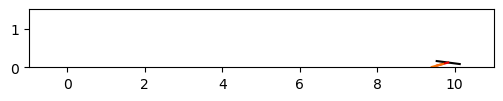

In [11]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1,dpi=100) #create axes
ax1.set_aspect('equal')

xmax = np.max([m.q[n,P,'x'].value for n in range(1,N+1)])

def plot_robot(i,P,m,ax): #update function for animation
    print(i)
    ax.clear()
    ax.set_xlim([-1,xmax+1])
    ax.set_ylim([0,1.5])
    
    #plot body
    body_xb = m.q[i,P,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,P,'thb'].value)
    body_yb = m.q[i,P,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,P,'thb'].value)
    body_xf = m.q[i,P,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,P,'thb'].value)
    body_yf = m.q[i,P,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,P,'thb'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,P,'thl'].value
    leg1_xt = m.q[i,P,'x'].value
    leg1_yt = m.q[i,P,'y'].value
    leg1_xb = m.q[i,P,'x'].value + m.len[('leg',1)]*sin(thA)
    leg1_yb = m.q[i,P,'y'].value - m.len[('leg',1)]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:red')
    
    #plot leg 2
    Lt = 0.5*m.len[('leg',1)] + m.q[i,P,'r'].value - 0.5*m.len[('leg',2)]
    Lb = 0.5*m.len[('leg',1)] + m.q[i,P,'r'].value + 0.5*m.len[('leg',2)]
    leg2_xt = m.q[i,P,'x'].value + Lt*sin(thA)
    leg2_yt = m.q[i,P,'y'].value - Lt*cos(thA)
    leg2_xb = m.q[i,P,'x'].value + Lb*sin(thA)
    leg2_yb = m.q[i,P,'y'].value - Lb*cos(thA)
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:orange')
    
update = lambda i: plot_robot(i,P,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1,3),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
